<a href="https://colab.research.google.com/github/felladib/H_SentimentAnalysis_REC/blob/main/HybSemRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import metrics
from keras.layers import Embedding, Multiply, Dense, Dot, Conv2D, Input, Flatten
from keras.layers import concatenate
from keras.models import Model

# **collection de données**

**SA_data**

In [ ]:
ptr = pd.read_csv('/content/drive/MyDrive/Train.csv')
pte = pd.read_csv('/content/drive/MyDrive/Test.csv')
pv = pd.read_csv('/content/drive/MyDrive/Valid.csv')

In [ ]:
X_train_rev = ptr['text']
y_train_rev = ptr['label']
X_test_rev = pte['text']
y_test_rev = pte['label']
X_val_rev = pv['text']
y_val_rev = pv['label']

**fake_reviews data**

In [ ]:
# open dataset pour cree la matrice de confiance :
dataset = pd.read_csv('/content/drive/MyDrive/shopping_full_dataset.csv' ,nrows = 20000) #open dataset

In [ ]:
# affichage de la matrice :
dataset.head()

,Unnamed: 0,user_id,item_id,text,rating,fans,average_stars,friends,vote_funny,useful,...,TV Mounting,Car Auctions,Food Trucks,Waterproofing,Water Delivery,Food Delivery Services,Korean,Chicken Shop,Hospitals,valuer_conf
0,0,0,1411,looking optometrist brady fantastic knowledgea...,4.5,5,3.93,982,16,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1,1,0,1823,fun best way absolutely adorable shop cornucop...,4.0,5,3.93,982,16,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
2,2,1,1990,went birthday lunch definitely list went big d...,4.5,4,4.37,94,5,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
3,3,2,224,special target pretty convenient location park...,4.0,18,3.64,8110,106,325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
4,4,2,383,wow place packed spirit place asked athletes a...,5.0,18,3.64,8110,106,325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850834


In [ ]:
# C'est juste pour cree la mtrice de confiance :
dataset   = dataset
dataset_u = dataset.copy()
dataset_i = dataset.copy()
dataset_i = dataset_i.sort_values(by=['item_id'],axis=0, ascending = True)

# **module de fake reviews**

In [ ]:
# relu fonction permet de retourner x or 0 dans le cas ou x<0
def relu(x):
    return (np.maximum(0,x))

In [ ]:
# relu fonction permet de retourner x or 0 dans le cas ou x<0
def relu(x):
    return (np.maximum(0,x))
#  build_confidence_M fonction permet de retourner un vecteur qui contient la valeur de confiance pour chaque row (user , item ) dans notre dataset
def build_confidence_M(dataset_item, dataset_user, emb_dataset ):
  confidence_M = np.zeros(dataset_user.shape[0]) # intialiser la matrice par des zeros
  i = 0
  for index, row in emb_dataset.iterrows():
    user   = row['user_id']
    item   = row['item_id']
    rating = row['rating']
    # recupere l user qu'on veut lui calcule la valeur de confinace par rapport un item
    if rating<= 3:
      nb1 = 0
      nb2 = 0
      sum1 = 0
      sum2 = 0
      #  recperer tt les ratings de cet user par rapport au autre items
      for x in dataset_user['user_id']:

        if (user == dataset['user_id'][x]):
          if (item != dataset['item_id'][x] and dataset['rating'][x] <= 3):
            nb1 = nb1+1
            sum1 = sum1 + dataset['rating'][x]
      #  la moyenne de ratings
      if(nb1!=0):
        result1 = sum1/nb1 #la somme des ratings divisé par le nombre de ratings (<=3)
        result1 = result1 - rating #rating : la note qu'a donné l'utilisateur considéré [i] à l'item considéré [i]
        result1 = abs(result1)
        result1 = result1 - 0.8  #0.8 :
        result1 = - relu(result1) # ReLU : permet de remplacer les resultats négatifs par 0
      else: result1 = 0
      #  recuperer tt les ratings donner  par les autre users a cet item
      for y in dataset_item['item_id']:

        if (item == dataset['item_id'][y]):
          if (user != dataset['user_id'][y] and dataset['rating'][y] <= 3):
            nb2 = nb2+1
            sum2 = sum2 + dataset['rating'][y]

    #   calcule la moyenne de ratings
      if(nb2!=0):
        result2 = sum2/nb2
        result2 = result2 - rating
        result2 = abs(result2)
        result2 = result2 - 0.8
        result2 = - relu(result2)
      else: result2 = 0
      result = result1 + result2
      result = math.exp(result)
      # return result
    # les meme etap si rating >3
    elif rating > 3:
      nb1 = 0
      nb2 = 0
      sum1 = 0
      sum2 = 0
      for x in dataset_user['user_id']:
        if (user == dataset['user_id'][x]):
          if (item != dataset['item_id'][x] and dataset['rating'][x] > 3):
            nb1 = nb1+1
            sum1 = sum1 + dataset['rating'][x]
      if(nb1!=0):
        result1 = sum1/nb1
        result1 = result1 - rating
        result1 = abs(result1)
        result1 = result1 - 0.8
        result1 = - relu(result1)
      else: result1 = 0
      for y in dataset_item['item_id']:
        if (item == dataset['item_id'][y]):
          if (user != dataset['user_id'][y] and dataset['rating'][y] > 3):
            nb2 = nb2+1
            sum2 = sum2 + dataset['rating'][y]
      if(nb2!=0):
        result2 = sum2/nb2
        result2 = result2 - rating
        result2 = abs(result2)
        result2 = result2 - 0.8
        result2 = - relu(result2)
      else: result2 = 0
      result = result1 + result2
      result = math.exp(result)
    # remplire la matrice par la valeur de confiance
    confidence_M[i]=result
    i = i+1
  return confidence_M

In [ ]:
# build la matrice de confiance :
conf_val = build_confidence_M(dataset_i , dataset_u , dataset[:1000])

In [ ]:
#  remplire la colonne de confiance pour chauqe user-item :
dataset['valuer_conf'] = conf_val

# **preprocessing avec bert model**

In [ ]:
# !pip uninstall tensorflow
!pip uninstall tensorflow-text
# !pip install tensorflow
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 94.6 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow_hub
# !pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
from keras.engine import training
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text ,training = False)

preprocessing_model = tf.keras.Model(inputs=text_input, outputs=outputs['sequence_output'])



# **module d'analyse de sentiment**

In [ ]:
from keras import metrics
rmse = metrics.RootMeanSquaredError()
precision = metrics.Precision()

## **classe LSTM**

In [ ]:
class MyLSTM(tf.keras.Model):
    def __init__(self,units,preprocessing_model,l1=0,l2=0 , droup_val=0):
        super(MyLSTM, self).__init__()
        self.preprocessing_model = preprocessing_model
        self.lstm                = tf.keras.layers.LSTM(units,
                                                        # input_shape=(1, 128,768),
                                                        return_sequences=True,
                                                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                                        name='lstm1')
        self.dropout             = tf.keras.layers.Dropout(droup_val , name='dropout')
        self.flatten             = tf.keras.layers.Flatten(name='flatten')
        self.dense1              = tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.l2( l2=l2),activation='tanh', name='dense1')
        self.dense2              = tf.keras.layers.Dense(16,activation='relu' , name='dense1')
        self.dense3              = tf.keras.layers.Dense(1 , activation = 'sigmoid' , name ='output')

    def call(self, inputs):
        x = self.preprocessing_model(inputs)
        x = self.lstm(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)



**entrainement LSTM**

In [ ]:
units = 32
l1= 5e-3
l2= 5e-3
BATCH_SIZE = 32
EPOCHS = 20
droup_val =0.3

In [ ]:
model_sa=MyLSTM(units,preprocessing_model,l1,l2 , droup_val)

In [ ]:
model_sa.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mae', metrics.RootMeanSquaredError()])

In [ ]:
history = model_sa.fit(X_train_rev, y_train_rev, epochs=EPOCHS, batch_size= BATCH_SIZE, validation_data=(X_val_rev, y_val_rev))

In [ ]:
import matplotlib.pyplot as plt
loss_curve= history.history["loss"]
acc_curve = history.history["accuracy"]
rmse_curve= history.history["root_mean_squared_error"]
mae_curve = history.history["mae"]

loss_val = history.history["val_loss"]
acc_val  = history.history["val_accuracy"]
rmse_val = history.history["val_root_mean_squared_error"]
mae_val  = history.history["val_mae"]

# ploter loss function
def ploter(title , curve , valid)
  plt.plot(curve , label = "train")
  plt.plot(valid , label = "validation")
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

ploter('loss' , loss_curve , loss_val)
ploter('rmse' , rmse_curve , rsme_val)
ploter('mae' , mae_curve , mae_val)
ploter('acc' , acc_curve , acc_val)


**test LSTM**

In [ ]:
score = model_sa.evaluate(X_test_rev , y_test_rev)

In [ ]:
score

## **classe BiLstm**

In [ ]:
class MyBiLstm(tf.keras.Model):
        def __init__(self,preprocessing_model,units ,l1=0,l2=0 ,droup_val=0):
            super(MyBiLstm, self).__init__()
            self.preprocessing_model = preprocessing_model
            self.bilstm              = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(units/2),
                                                                    return_sequences=True,
                                                                    # input_shape=(None , 128 , 768),
                                                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                                                    name='bilstm1'))
            self.dropout             = tf.keras.layers.Dropout(droup_val)
            self.flatten             = tf.keras.layers.Flatten()
            self.dense1              = tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.l2(l2=l2),activation='tanh')
            self.dense2              = tf.keras.layers.Dense(5,kernel_regularizer=tf.keras.regularizers.l2( l2=l2),activation='relu')
            self.dense3              = tf.keras.layers.Dense(1 , activation = 'sigmoid' , name ='output')


        def call(self, inputs):
            x = self.preprocessing_model(inputs)
            x = self.bilstm(x)
            x = self.dropout(x)
            x = self.flatten(x)
            x = self.dense1(x)
            x = self.dense2(x)
            return self.dense3(x)


**Entrainement BiLSTM**

In [ ]:
units = 16
l1= 5e-3
l2= 5e-3
droup_val = 0.3
BATCH_SIZE = 32
EPOCHS = 15

In [ ]:
model_sa=MyBiLstm(preprocessing_model,units,l1,l2 , droup_val)

In [ ]:
model_sa.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mae', metrics.RootMeanSquaredError()])

In [ ]:
history = model_sa.fit(X_train_rev, y_train_rev, epochs=EPOCHS, batch_size= BATCH_SIZE, validation_data=(X_val_rev, y_val_rev))

In [ ]:
import matplotlib.pyplot as plt
loss_curve= history.history["loss"]
acc_curve = history.history["accuracy"]
rmse_curve= history.history["root_mean_squared_error"]
mae_curve = history.history["mae"]

loss_val = history.history["val_loss"]
acc_val  = history.history["val_accuracy"]
rmse_val = history.history["val_root_mean_squared_error"]
mae_val  = history.history["val_mae"]

# ploter loss function
def ploter(title , curve , valid)
  plt.plot(curve , label = "train")
  plt.plot(valid , label = "validation")
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

ploter('loss' , loss_curve , loss_val)
ploter('rmse' , rmse_curve , rsme_val)
ploter('mae' , mae_curve , mae_val)
ploter('acc' , acc_curve , acc_val)



**test BiLstm**

In [ ]:
scores= model_sa.evaluate(X_test_rev,y_test_rev,verbose=0)

In [ ]:
scores

[0.479573130607605, 0.8543999791145325, 0.2415805160999298, 0.3291526734828949]

In [ ]:
print(y_test_rev[1000:1007])
print(X_test_rev[1000:1007])
model_sa.predict(X_test_rev[1000:1007])

## **classe BiLstmCnn**

In [ ]:
class MyBiLstmCnn(tf.keras.Model):
        def __init__(self,preprocessing_model , units , l1=0 , l2=0 , droup_val = 0):
            super(MyBiLstmCnn, self).__init__()
            self.preprocessing_model = preprocessing_model
            self.bilstm              = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(units/2),
                                                                    return_sequences=True,
                                                                    input_shape=(None , 128 , 768),
                                                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                                                    name='bilstm1'))
            self.cnn                 = tf.keras.layers.Conv1D(64,3,activation="relu",padding="valid")
            self.maxpooling          = tf.keras.layers.GlobalMaxPooling1D()
            self.dropout             = tf.keras.layers.Dropout(droup_val)
            self.flatten             = tf.keras.layers.Flatten()
            self.dense1              = tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.l2(l2=l2),activation='relu')
            # self.dense2              = tf.keras.layers.Dense(5 , activation='relu')
            self.dense3              = tf.keras.layers.Dense(1 , activation = 'sigmoid' , name ='output')


        def call(self, inputs):
            x = self.preprocessing_model(inputs)
            x = self.bilstm(x)
            x = self.cnn(x)
            x = self.maxpooling (x)
            x = self.dropout(x)
            x = self.flatten(x)
            x = self.dense1(x)
            # x = self.dense2(x)
            return self.dense3(x)


**TEST Bilstm cnn**

In [ ]:
units = 32
l1= 5e-3
l2= 5e-3
droup_val = 0.5
EPOCH = 15
BATCH_SIZE = 32

In [ ]:
model_sa=MyBiLstmCnn(preprocessing_model , units , l1, l2 , droup_val)

In [ ]:
model_sa.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mae', metrics.RootMeanSquaredError()])

In [ ]:
history = model_sa.fit(X_train_rev, y_train_rev, epochs=EPOCH, batch_size= BATCH_SIZE, validation_data=(X_val_rev, y_val_rev))

Epoch 1/15
1250/1250 [==============================] - 586s 444ms/step - loss: 1.2382 - accuracy: 0.7909 - mae: 0.2907 - root_mean_squared_error: 0.3784 - val_loss: 0.5749 - val_accuracy: 0.8334 - val_mae: 0.2309 - val_root_mean_squared_error: 0.3422
Epoch 2/15
1250/1250 [==============================] - 568s 454ms/step - loss: 0.5860 - accuracy: 0.8312 - mae: 0.2429 - root_mean_squared_error: 0.3466 - val_loss: 0.5800 - val_accuracy: 0.8266 - val_mae: 0.2393 - val_root_mean_squared_error: 0.3467
Epoch 3/15
1250/1250 [==============================] - 551s 441ms/step - loss: 0.5752 - accuracy: 0.8303 - mae: 0.2404 - root_mean_squared_error: 0.3457 - val_loss: 0.5880 - val_accuracy: 0.8148 - val_mae: 0.2408 - val_root_mean_squared_error: 0.3605
Epoch 4/15
1250/1250 [==============================] - 549s 439ms/step - loss: 0.5694 - accuracy: 0.8335 - mae: 0.2368 - root_mean_squared_error: 0.3434 - val_loss: 0.5540 - val_accuracy: 0.8428 - val_mae: 0.2180 - val_root_mean_squared_error:

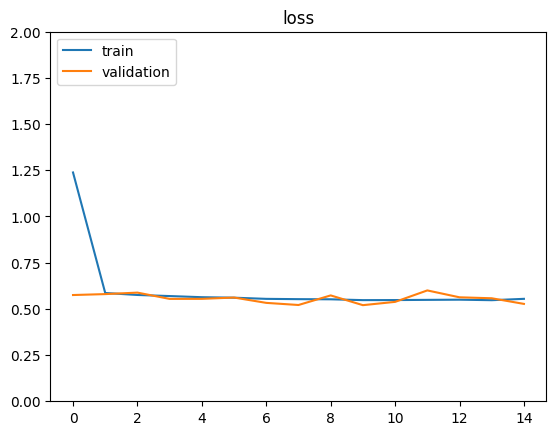

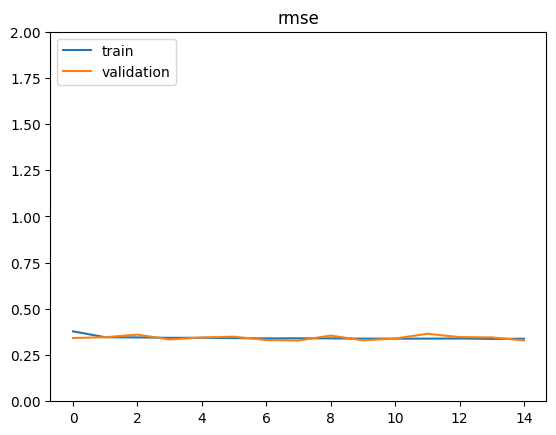

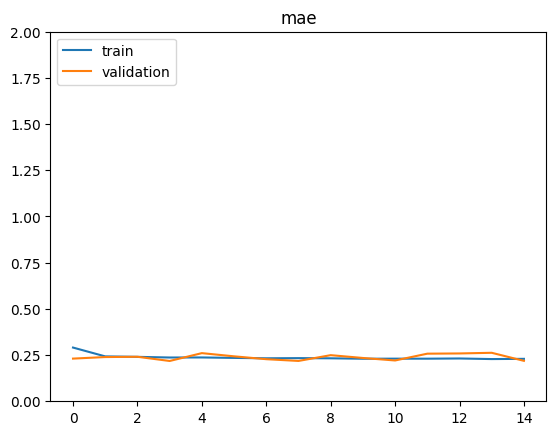

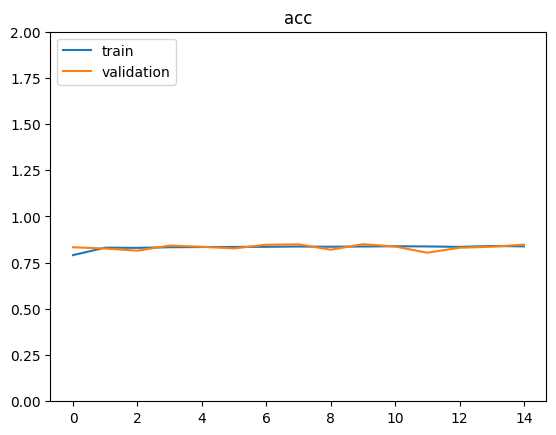

In [ ]:
import matplotlib.pyplot as plt
loss_curve= history.history["loss"]
acc_curve = history.history["accuracy"]
rmse_curve= history.history["root_mean_squared_error"]
mae_curve = history.history["mae"]

loss_val = history.history["val_loss"]
acc_val  = history.history["val_accuracy"]
rmse_val = history.history["val_root_mean_squared_error"]
mae_val  = history.history["val_mae"]

# ploter loss function
def ploter(title , curve , valid):
  plt.plot(curve , label = "train")
  plt.plot(valid , label = "validation")
  plt.legend(loc='upper left')
  plt.ylim(0,2)
  plt.title(title)
  plt.show()

ploter('loss' , loss_curve , loss_val)
ploter('rmse' , rmse_curve , rmse_val)
ploter('mae' , mae_curve , mae_val)
ploter('acc' , acc_curve , acc_val)

**test BiLstm_Cnn**

In [ ]:
score = model_sa.evaluate(X_test_rev , y_test_rev)

157/157 [==============================] - 58s 365ms/step - loss: 0.5272 - accuracy: 0.8548 - mae: 0.2169 - root_mean_squared_error: 0.3279


In [ ]:
score

[0.5271879434585571,
 0.8547999858856201,
 0.21690131723880768,
 0.3279414474964142]

## **classe BiLstmRnn**

In [ ]:
class MyBiLstmRnn(tf.keras.Model):
        def __init__(self, units ,preprocessing_model  , l1=0 , l2=0  ,droup_val):
            super(MyBiLstmRnn, self).__init__()
            self.preprocessing_model = preprocessing_model
            # self.first_layer         = tf.keras.layers.Dense(units,activation='relu')
            self.bilstm              = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(units/2),
                                                                    return_sequences=True,
                                                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                                                    name='bilstm1'))

            self.rnn                 = tf.keras.layers.SimpleRNN(units ,
                                                        return_sequences=True ,
                                                        input_shape=(None , 128 , 768),
                                                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                                        name = 'rnn1')
            self.dropout             = tf.keras.layers.Dropout(droup_val)
            self.flatten             = tf.keras.layers.Flatten()
            self.dense1              = tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),activation='relu')
            # self.dense2              = tf.keras.layers.Dense(5,,activation='relu')
            self.dense2              = tf.keras.layers.Dense(1 , activation = 'sigmoid' , name ='output')


        def call(self, inputs):
            x = self.preprocessing_model(inputs)
            x = self.bilstm(x)
            x = self.rnn(x)
            x = self.dropout(x)
            x = self.flatten(x)
            x = self.dense1(x)
            # x = self.dense2(x)
            return self.dense3(x)



**Entrainement LSTM**

In [ ]:
units = 16
l1= 5e-3
l2= 5e-3
droup_val = 0.5
EPOCH = 15
BATCH_SIZE = 32

In [ ]:
model_sa=MyBiLstmRnn(units , preprocessing_model,l1,l2 , droup_val )

In [ ]:
from keras import metrics
rmse = metrics.RootMeanSquaredError()
precision = metrics.Precision()

In [ ]:
model_sa.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mae',rmse , precision])

In [ ]:
history = model_sa.fit(X_train_rev, y_train_rev, epochs=25, batch_size= 32, validation_data=(X_val_rev, y_val_rev))

Epoch 1/25
1250/1250 [==============================] - 710s 552ms/step - loss: 1.9870 - accuracy: 0.7814 - mae: 0.3154 - root_mean_squared_error: 0.3931 - precision: 0.7823 - val_loss: 0.8364 - val_accuracy: 0.8066 - val_mae: 0.2853 - val_root_mean_squared_error: 0.3714 - val_precision: 0.8400
Epoch 2/25
1250/1250 [==============================] - 656s 525ms/step - loss: 0.8066 - accuracy: 0.8044 - mae: 0.2828 - root_mean_squared_error: 0.3734 - precision: 0.8014 - val_loss: 0.7547 - val_accuracy: 0.8080 - val_mae: 0.2705 - val_root_mean_squared_error: 0.3643 - val_precision: 0.8396
Epoch 3/25
1250/1250 [==============================] - 683s 547ms/step - loss: 0.7740 - accuracy: 0.8076 - mae: 0.2765 - root_mean_squared_error: 0.3696 - precision: 0.8010 - val_loss: 0.7492 - val_accuracy: 0.8226 - val_mae: 0.2502 - val_root_mean_squared_error: 0.3567 - val_precision: 0.7936
Epoch 4/25
1250/1250 [==============================] - 682s 545ms/step - loss: 0.7625 - accuracy: 0.8073 - mae:

In [ ]:
import matplotlib.pyplot as plt
loss_curve= history.history["loss"]
acc_curve = history.history["accuracy"]
rmse_curve= history.history["root_mean_squared_error"]
mae_curve = history.history["mae"]

loss_val = history.history["val_loss"]
acc_val  = history.history["val_accuracy"]
rmse_val = history.history["val_root_mean_squared_error"]
mae_val  = history.history["val_mae"]

# ploter loss function
def ploter(title , curve , valid):
  plt.plot(curve , label = "train")
  plt.plot(valid , label = "validation")
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

ploter('loss' , loss_curve , loss_val)
ploter('rmse' , rmse_curve , rmse_val)
ploter('mae' , mae_curve , mae_val)
ploter('acc' , acc_curve , acc_val)

**test BiLstm_Rnn**

In [ ]:
scores = model_sa.evaluate(X_train_rev , y_train_rev)

In [ ]:
scores

## **classe LstmCnn**

In [ ]:
class MyLstmCnn(tf.keras.Model):
    def __init__(self,preprocessing_model , units , l1=0 , l2=0 , droup_val=0):
        super(MyLstmCnn, self).__init__()
        self.preprocessing_model = preprocessing_model
        self.lstm                = tf.keras.layers.LSTM(units,
                                               return_sequences=True,
                                               input_shape=(None , 128 , 768),
                                               kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                               dropout=0.2 ,
                                               name = 'lstm1')
        self.cnn                 = tf.keras.layers.Conv1D(64,3,activation="relu",padding="valid")
        self.dropout             = tf.keras.layers.Dropout((droup_val))
        self.flatten             = tf.keras.layers.Flatten()
        self.dense1              = tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),activation='relu')
        # self.dense2              = tf.keras.layers.Dense(5,kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),activation='relu')
        self.dense3              = tf.keras.layers.Dense(1 , activation = 'sigmoid' , name =' output')


    def call(self, inputs):
        x = self.preprocessing_model(inputs)
        x = self.lstm(x)
        x = self.cnn (x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        # x = self.dense2(x)
        return self.dense3(x)

**Entrainment LSTM CNN**

In [ ]:
units = 16
l1= 5e-3
l2= 5e-3
droup_val = 0.5
EPOCH = 15
BATCH_SIZE = 32

In [ ]:
model_sa=MyLstmCnn(preprocessing_model,units,l1,l2 , droup_val)

In [ ]:
model_sa.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mae', rmse , precision])

In [ ]:
import matplotlib.pyplot as plt
loss_curve= history.history["loss"]
acc_curve = history.history["accuracy"]
rmse_curve= history.history["root_mean_squared_error"]
mae_curve = history.history["mae"]

loss_val = history.history["val_loss"]
acc_val  = history.history["val_accuracy"]
rmse_val = history.history["val_root_mean_squared_error"]
mae_val  = history.history["val_mae"]

# ploter loss function
def ploter(title , curve , valid):
  plt.plot(curve , label = "train")
  plt.plot(valid , label = "validation")
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

ploter('loss' , loss_curve , loss_val)
ploter('rmse' , rmse_curve , rmse_val)
ploter('mae' , mae_curve , mae_val)
ploter('acc' , acc_curve , acc_val)

**test Lstm_Cnn**

In [ ]:
scores = model_sa.evaluate(X_test_rev , y_test_rev)

In [ ]:
scores

## **classe LstmRnn**

In [ ]:
class MyLstmRnn(tf.keras.Model):
    def __init__(self, preprocessing_model , units , l1=0 , l2=0 , droup_val=0):
        super(MyLstmRnn, self).__init__()
        self.preprocessing_model = preprocessing_model
        self.lstm                = tf.keras.layers.LSTM(units,
                                                      return_sequences=True,
                                                      kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                                      input_shape=(None ,128 , 768),
                                                      name='lstm1')

        self.rnn                 = tf.keras.layers.SimpleRNN(units ,
                                                              return_sequences=True ,
                                                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
                                                              name = 'rnn1')
        self.dropout             = tf.keras.layers.Dropout(droup_val)
        self.flatten             = tf.keras.layers.Flatten()
        self.dense1              = tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),activation='relu')
        # self.dense2              = tf.keras.layers.Dense(5,kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),activation='relu')
        self.dense3              = tf.keras.layers.Dense(1 , activation = 'sigmoid' , name =' output')

    def call(self, inputs):
        x = self.preprocessing_model(inputs)
        x = self.lstm(x)
        x = self.rnn(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        # x = self.dense2(x)
        return self.dense3(x)

**entrainement LSTM Rnn**

In [ ]:
units = 16
l1= 5e-3
l2= 5e-3
droup_val = 0.5
EPOCH = 15
BATCH_SIZE = 32

In [ ]:
model_sa=MyLstmRnn( preprocessing_model , units , l1 , l2 , droup_val)

In [ ]:
model_sa.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mae', rmse , precision ])

In [ ]:
import matplotlib.pyplot as plt
loss_curve= history.history["loss"]
acc_curve = history.history["accuracy"]
rmse_curve= history.history["root_mean_squared_error"]
mae_curve = history.history["mae"]

loss_val = history.history["val_loss"]
acc_val  = history.history["val_accuracy"]
rmse_val = history.history["val_root_mean_squared_error"]
mae_val  = history.history["val_mae"]

# ploter loss function
def ploter(title , curve , valid):
  plt.plot(curve , label = "train")
  plt.plot(valid , label = "validation")
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

ploter('loss' , loss_curve , loss_val)
ploter('rmse' , rmse_curve , rmse_val)
ploter('mae' , mae_curve , mae_val)
ploter('acc' , acc_curve , acc_val)

**test Lstm_Rnn**

In [ ]:
scores = model_sa.evaluat(X_test_rev , y_test_rev)

In [ ]:
scores

## **new model**

In [ ]:
# class Concate(tf.keras.Model):
#     def __init__(self,preprocessing_model , units , l1=0 , l2=0):
#         super(Concate, self).__init__()

#         # Define the four models
#         self.LstmRnn   = MyLstmRnn(preprocessing_model , units , l1 , l2)
#         self.LstmCnn   = MyLstmCnn(preprocessing_model , units  , l1 , l2)
#         self.BiLstmRnn = MyBiLstmRnn(preprocessing_model , units  , l1 , l2)
#         self.BiLstmCnn = MyBiLstmCnn(preprocessing_model , units  , l1 , l2)

#         # Define the concatenate layer
#         self.max_layer = tf.keras.layers.Maximum()

#         # Define the dense layer
#         self.dense1 = tf.keras.layers.Dense(16,
#                                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
#                                            activation='relu')
#         self.dense2 = tf.keras.layers.Dense(1,
#                                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2),
#                                            activation='sigmoid')

#     def call(self, inputs):
#         # Pass the inputs through each model
#         lstm_rnn_output = self.LstmRnn(inputs)
#         lstm_cnn_output = self.LstmCnn(inputs)
#         bilstm_rnn_output = self.BiLstmRnn(inputs)
#         bilstm_cnn_output = self.BiLstmCnn(inputs)

#         # Concatenate the outputs using the concatenate layer
#         max_output = self.max_layer([lstm_cnn_output, lstm_rnn_output, bilstm_cnn_output, bilstm_rnn_output])

#         # Pass the concatenated output through the dense layer
#         dense1 = self.dense1(max_output)

#         return self.dense2(dense1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Concatenate, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import numpy as np

In [ ]:
class AddNorm(tf.keras.layers.Layer):
    """Residual connection followed by layer normalization."""

    def __init__(self, name=None, **kwargs):
        super().__init__()
        if name: self._name = name
        self.ln = LayerNormalization(**kwargs)
        self.add = Add()

    def call(self, X):
        return self.ln(self.add(X))

In [ ]:
from keras.backend import dropout
class HybLstm(Model):
  def __init__(self,units,preprocessing_model,l1=0,l2=0):
    super().__init__()
    self.preprocessing_model = preprocessing_model
    self.first_layer = Dense(units,activation='relu')
    self.lstm1 = Bidirectional(LSTM(int(units/2), return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2) , dropout = 0.5))
    self.lstm2 = Bidirectional(LSTM(int(units/2), return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2) , dropout = 0.5))
    self.lstm3 = LSTM(units, return_sequences=True, return_state=True, kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2) , dropout = 0.5)

    self.add1,self.add2 = AddNorm(),AddNorm()

    self.concat = Concatenate()
    self.dense1 = Dense(units,activation='relu')
    self.final_layer = Dense(1,activation="sigmoid")

  def call(self,x):
    x  = self.preprocessing_model(x)
    x  = self.first_layer(x)
    xl = self.lstm1(x)
    x  = self.add1([x,xl])
    xl = self.lstm2(x)
    x  = self.add2([x,xl])

    _, final_memory_state, final_carry_state  = self.lstm3(x)
    states = self.concat([final_memory_state, final_carry_state])
    states = self.dense1(states)
    out    = self.final_layer(states)
    return out

  def train(self,X_train,Y_train, batch_size , epochs, learning_rate,**kwargs):
    print("    training ...")
    # Learning rate decay
    callbacks = []
    def scheduler(epoch, lr):
      if epoch<2:
        return learning_rate/10
      else:
        return learning_rate * np.exp(-4 * epoch / epochs)

    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

    # Compile the model :
    self.compile(loss='binary_crossentropy' ,
                 optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics = ["accuracy" , rmse , 'mae' , precision])
    # Fitting the data :
    self.train_history = self.fit(X_train,Y_train,
                                  batch_size = BATCH_SIZE,
                                  epochs=EPOCHS,
                                  callbacks=callbacks,
                                  ** kwargs)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 5e-3

In [ ]:
model = HybLstm(units=32,preprocessing_model=preprocessing_model,l1=1e-5,l2=1e-5)

In [ ]:
history = model.train(X_train_rev,y_train_rev, batch_size = BATCH_SIZE, epochs=EPOCHS, learning_rate=LEARNING_RATE , validation_data=(X_val_rev , y_val_rev))

    training ...
Epoch 1/15
1250/1250 [==============================] - 581s 455ms/step - loss: 0.4644 - accuracy: 0.7822 - root_mean_squared_error: 0.3508 - mae: 0.2905 - precision: 0.8189 - val_loss: 0.4924 - val_accuracy: 0.7864 - val_root_mean_squared_error: 0.3938 - val_mae: 0.2458 - val_precision: 0.9238 - lr: 5.0000e-04
Epoch 2/15
1250/1250 [==============================] - 563s 451ms/step - loss: 0.3612 - accuracy: 0.8468 - root_mean_squared_error: 0.3294 - mae: 0.2171 - precision: 0.8440 - val_loss: 0.3459 - val_accuracy: 0.8572 - val_root_mean_squared_error: 0.3224 - val_mae: 0.2165 - val_precision: 0.8644 - lr: 5.0000e-04
Epoch 3/15
1250/1250 [==============================] - 563s 451ms/step - loss: 0.3559 - accuracy: 0.8512 - root_mean_squared_error: 0.3268 - mae: 0.2138 - precision: 0.8503 - val_loss: 0.3530 - val_accuracy: 0.8536 - val_root_mean_squared_error: 0.3267 - val_mae: 0.1961 - val_precision: 0.8148 - lr: 0.0029
Epoch 4/15
1250/1250 [==========================

In [ ]:
model.evaluate(X_test_rev , y_test_rev)

157/157 [==============================] - 59s 374ms/step - loss: 0.5945 - accuracy: 0.8592 - root_mean_squared_error: 0.3496 - mae: 0.1451 - precision: 0.8547


[0.5945040583610535,
 0.8592000007629395,
 0.34960469603538513,
 0.14513042569160461,
 0.8546671867370605]

overfitting





In [ ]:
from keras import metrics
rmse = metrics.RootMeanSquaredError()
precision = metrics.Precision()

## ***save sentiment model***

In [ ]:
model_sa.save('/content/drive/MyDrive/concat_modelSA', save_format='tf')

In [ ]:
loaded_model_SA = tf.keras.models.load_model('/content/drive/MyDrive/concat_modelSA')

In [ ]:

sentiment = loaded_model_SA.predict(dataset['text'])


316/316 [==============================] - 110s 340ms/step


In [ ]:
sentiment

array([[0.8124601 ],
       [0.9521889 ],
       [0.6658738 ],
       ...,
       [0.65334785],
       [0.50953776],
       [0.54554576]], dtype=float32)

In [ ]:
dataset['sentiment']= sentiment

## ***enregistrer score de sentiment et la confiance***

In [ ]:
dataset.to_csv(r'/content/drive/MyDrive/datasetwithconfvalue.csv') # enregistre update dataset
dataset.head()

,Unnamed: 0,user_id,item_id,text,rating,fans,average_stars,friends,vote_funny,useful,...,Car Auctions,Food Trucks,Waterproofing,Water Delivery,Food Delivery Services,Korean,Chicken Shop,Hospitals,valuer_conf,sentiment
0,0,0,1411,looking optometrist brady fantastic knowledgea...,4.5,5,3.93,982,16,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.812460
1,1,0,1823,fun best way absolutely adorable shop cornucop...,4.0,5,3.93,982,16,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.952189
2,2,1,1990,went birthday lunch definitely list went big d...,4.5,4,4.37,94,5,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.665874
3,3,2,224,special target pretty convenient location park...,4.0,18,3.64,8110,106,325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.494975
4,4,2,383,wow place packed spirit place asked athletes a...,5.0,18,3.64,8110,106,325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.850834,0.870697


## **filtring model_data**

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/yelpdatasetwithconfsent.csv',nrows = 20000) #open dataset

In [ ]:
dataset.head()

In [ ]:
# def ponderation(datset , alpha):
#     for index, row in dataset.iterrows():
#       row['rating'] = row['rating']/5
#       row['rating'] = (alpha * row['rating']) + (1-alpha)*(row['valuer_conf']*row['sentiment'])
#       row['rating'] = row['rating']*5
def ponderation(dataset, alpha):
    dataset['updated_rating'] = dataset['rating'] / 5
    dataset['updated_rating'] = (alpha * dataset['updated_rating']) + (1 - alpha) * (dataset['valuer_conf'] * dataset['sentiment'])
    dataset['updated_rating'] = dataset['updated_rating'] * 5

In [ ]:
ponderation(dataset , 0.7)

In [ ]:
dataset.head()

In [ ]:
def dataset_split(dataset): #normal testset
    # Spliting into X and y
    X = dataset[['user_id', 'item_id', 'text','fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
        'profile','cute','list','note','plain',
        'cool','funny','writer','photos','Shopping', 'Books', 'Mags', 'Music & Video', 'Bookstores',
        'Baby Gear & Furniture', 'Home Decor', 'Furniture Stores', 'Home & Garden', 'Auction Houses',
        'Active Life', 'Fashion', 'Toy Stores', 'Hobby Shops', 'Comic Books', 'Department Stores',
        'Grocery', 'Food', 'Electronics', 'Jewelry', 'Outdoor Gear', 'Golf Lessons', 'Sporting Goods',
        'Golf Equipment', 'Golf', 'Fitness & Instruction', 'Sports Wear', 'Flooring', 'Home Services',
        'Kitchen & Bath', 'Building Supplies', 'Interior Design', 'Hardware Stores', 'Appliances']]
    y = dataset['updated_rating']
    X_train , y_train , X_test , y_test = train_test_split(X , y , test_size=0.2 , random_state=0)
    return X_train , y_train , X_test , y_test


In [ ]:
X_train, X_test, y_train, y_test = dataset_split(dataset)

In [ ]:
train_userDATA = X_train[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
        'profile','cute','list','note','plain',
        'cool','funny','writer','photos']] #17

train_itemDATA = X_train[['Shopping', 'Books', 'Mags', 'Music & Video',
                          'Bookstores', 'Baby Gear & Furniture', 'Home Decor',
                          'Furniture Stores', 'Home & Garden', 'Auction Houses',
                          'Active Life', 'Fashion', 'Toy Stores', 'Hobby Shops',
                          'Comic Books', 'Department Stores', 'Grocery', 'Food',
                          'Electronics', 'Jewelry', 'Outdoor Gear', 'Golf Lessons',
                          'Sporting Goods', 'Golf Equipment', 'Golf', 'Fitness & Instruction',
                          'Sports Wear', 'Flooring', 'Home Services', 'Kitchen & Bath',
                          'Building Supplies', 'Interior Design', 'Hardware Stores', 'Appliances']] #34

In [ ]:
train_userID = X_train['user_id']
train_itemID = X_train['item_id']

In [ ]:
# y_train.astype('float64')# train_userID, train_itemID, train_userDATA, train_itemDATA

In [ ]:
def getnum_user_item(X_train):
    num_users = int(max(X_train.user_id.max()+1,X_test.user_id.max()+1))
    num_items = int(max(X_train.item_id.max()+1,X_test.item_id.max()+1))
    return num_users , num_items

num_users , num_items = getnum_user_item(X_train)

In [ ]:
print(num_users , num_items )

3314 2874
